<a href="https://colab.research.google.com/github/junwin/colab/blob/main/kerasCatyNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Dependancies
import pandas as pd
! pip install tensorflow==2.4.0
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
from tensorflow.keras import regularizers
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler


from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [35]:
url="https://junwin.github.io/HouseData3.csv"
rawData=pd.read_csv(url).sample(frac=1)
rawData.describe()

,MLS#,YearClosed,SoldPr,Locale,Zip,Area,Rooms,FullBaths,HalfBaths,Beds,BsmtBeds,GarageSpaces,ParkingSpaces
count,9.605000e+03,9605.000000,9.605000e+03,9605.000000,9605.000000,9605.000000,9605.000000,9605.000000,9605.000000,9605.000000,9605.000000,9605.000000,9605.000000
mean,1.037041e+07,2019.130765,4.643093e+05,78.721603,60079.478605,2222.006767,7.968974,2.225299,0.549922,3.222957,0.144300,1.660718,0.409787
std,3.808318e+05,0.948912,3.246592e+05,59.308417,67.705670,1243.632265,2.500578,0.987977,0.578789,1.033955,0.388828,1.342160,3.543110
min,8.866215e+06,2017.000000,2.500000e+04,2.000000,60002.000000,372.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.013837e+07,2019.000000,2.600000e+05,53.000000,60053.000000,1344.000000,6.000000,2.000000,0.000000,3.000000,0.000000,1.000000,0.000000
50%,1.043821e+07,2019.000000,3.650000e+05,62.000000,60062.000000,1868.000000,8.000000,2.000000,1.000000,3.000000,0.000000,2.000000,0.000000
75%,1.067198e+07,2020.000000,5.750000e+05,76.000000,60077.000000,2750.000000,9.000000,3.000000,1.000000,4.000000,0.000000,2.000000,0.000000
max,1.095755e+07,2021.000000,4.300000e+06,201.000000,63104.000000,17365.000000,18.000000,8.000000,5.000000,11.000000,3.000000,79.000000,308.000000


In [36]:
selectedFeatures = rawData[['YearClosed', 'Type', 'Area', 'Zip', 'Rooms','FullBaths','Beds','GarageSpaces']]
prices = rawData['SoldPr']
SAMPLES = len(selectedFeatures.index)
featureCount = len(selectedFeatures.columns)

In [39]:

selectedFeatures['target'] = rawData['SoldPr']

# Drop un-used columns.
#dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
print(selectedFeatures.dtypes)

YearClosed        int64
Type             object
Area              int64
Zip               int64
Rooms             int64
FullBaths         int64
Beds            float64
GarageSpaces    float64
target            int64
dtype: object


In [23]:
train, test = train_test_split(selectedFeatures, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')



6147 train examples
1537 validation examples
1921 test examples


In [10]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [11]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)


In [13]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Zip'])
print('A batch of targets:', label_batch )


Every feature: ['YearClosed', 'Type', 'Area', 'Zip', 'Rooms', 'FullBaths', 'Beds', 'GarageSpaces']
A batch of ages: tf.Tensor([60062 60062 60025 60062 60053], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([ 310000  415000  405000 1030000  210000], shape=(5,), dtype=int64)


In [26]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [14]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Prepare a Dataset that only yields our feature.
  feature_ds = feature_ds.map(index)

  # Learn the space of possible indices.
  encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))


In [15]:
type_col = train_features['Type']
layer = get_category_encoding_layer('Type', train_ds, 'string')
layer(type_col)


<tf.Tensor: shape=(5, 6), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)>

In [21]:
zip_type_col = train_features['Zip']
category_encoding_layer = get_category_encoding_layer('Zip', train_ds,
                                                      'int64', 5)
category_encoding_layer(zip_type_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [22]:
yc_type_col = train_features['YearClosed']
category_encoding_layer = get_category_encoding_layer('YearClosed', train_ds,
                                                      'int64', 5)
category_encoding_layer(yc_type_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

In [41]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


In [42]:
all_inputs = []
encoded_features = []

# Numeric features.
# ['YearClosed', 'Type', 'Area', 'Zip', 'Rooms', 'FullBaths', 'Beds', 'GarageSpaces']
for header in ['Area', 'Rooms', 'FullBaths', 'Beds', 'GarageSpaces']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)


In [43]:
# Categorical features encoded as integers.
zip_col = tf.keras.Input(shape=(1,), name='Zip', dtype='int64')
zip_encoding_layer = get_category_encoding_layer('Zip', train_ds, dtype='int64',
                                             max_tokens=5)
encoded_zip_col = zip_encoding_layer(zip_col)
all_inputs.append(zip_col)
encoded_features.append(encoded_zip_col)

yc_col = tf.keras.Input(shape=(1,), name='YearClosed', dtype='int64')
yc_encoding_layer = get_category_encoding_layer('YearClosed', train_ds, dtype='int64',
                                             max_tokens=5)
encoded_yc_col = yc_encoding_layer(yc_col)
all_inputs.append(yc_col)
encoded_features.append(encoded_yc_col)


In [44]:
# Categorical features encoded as string.
categorical_cols = ['Type']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


In [50]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
#x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

#model_1.add(keras.layers.Dense(16, activation='relu'))

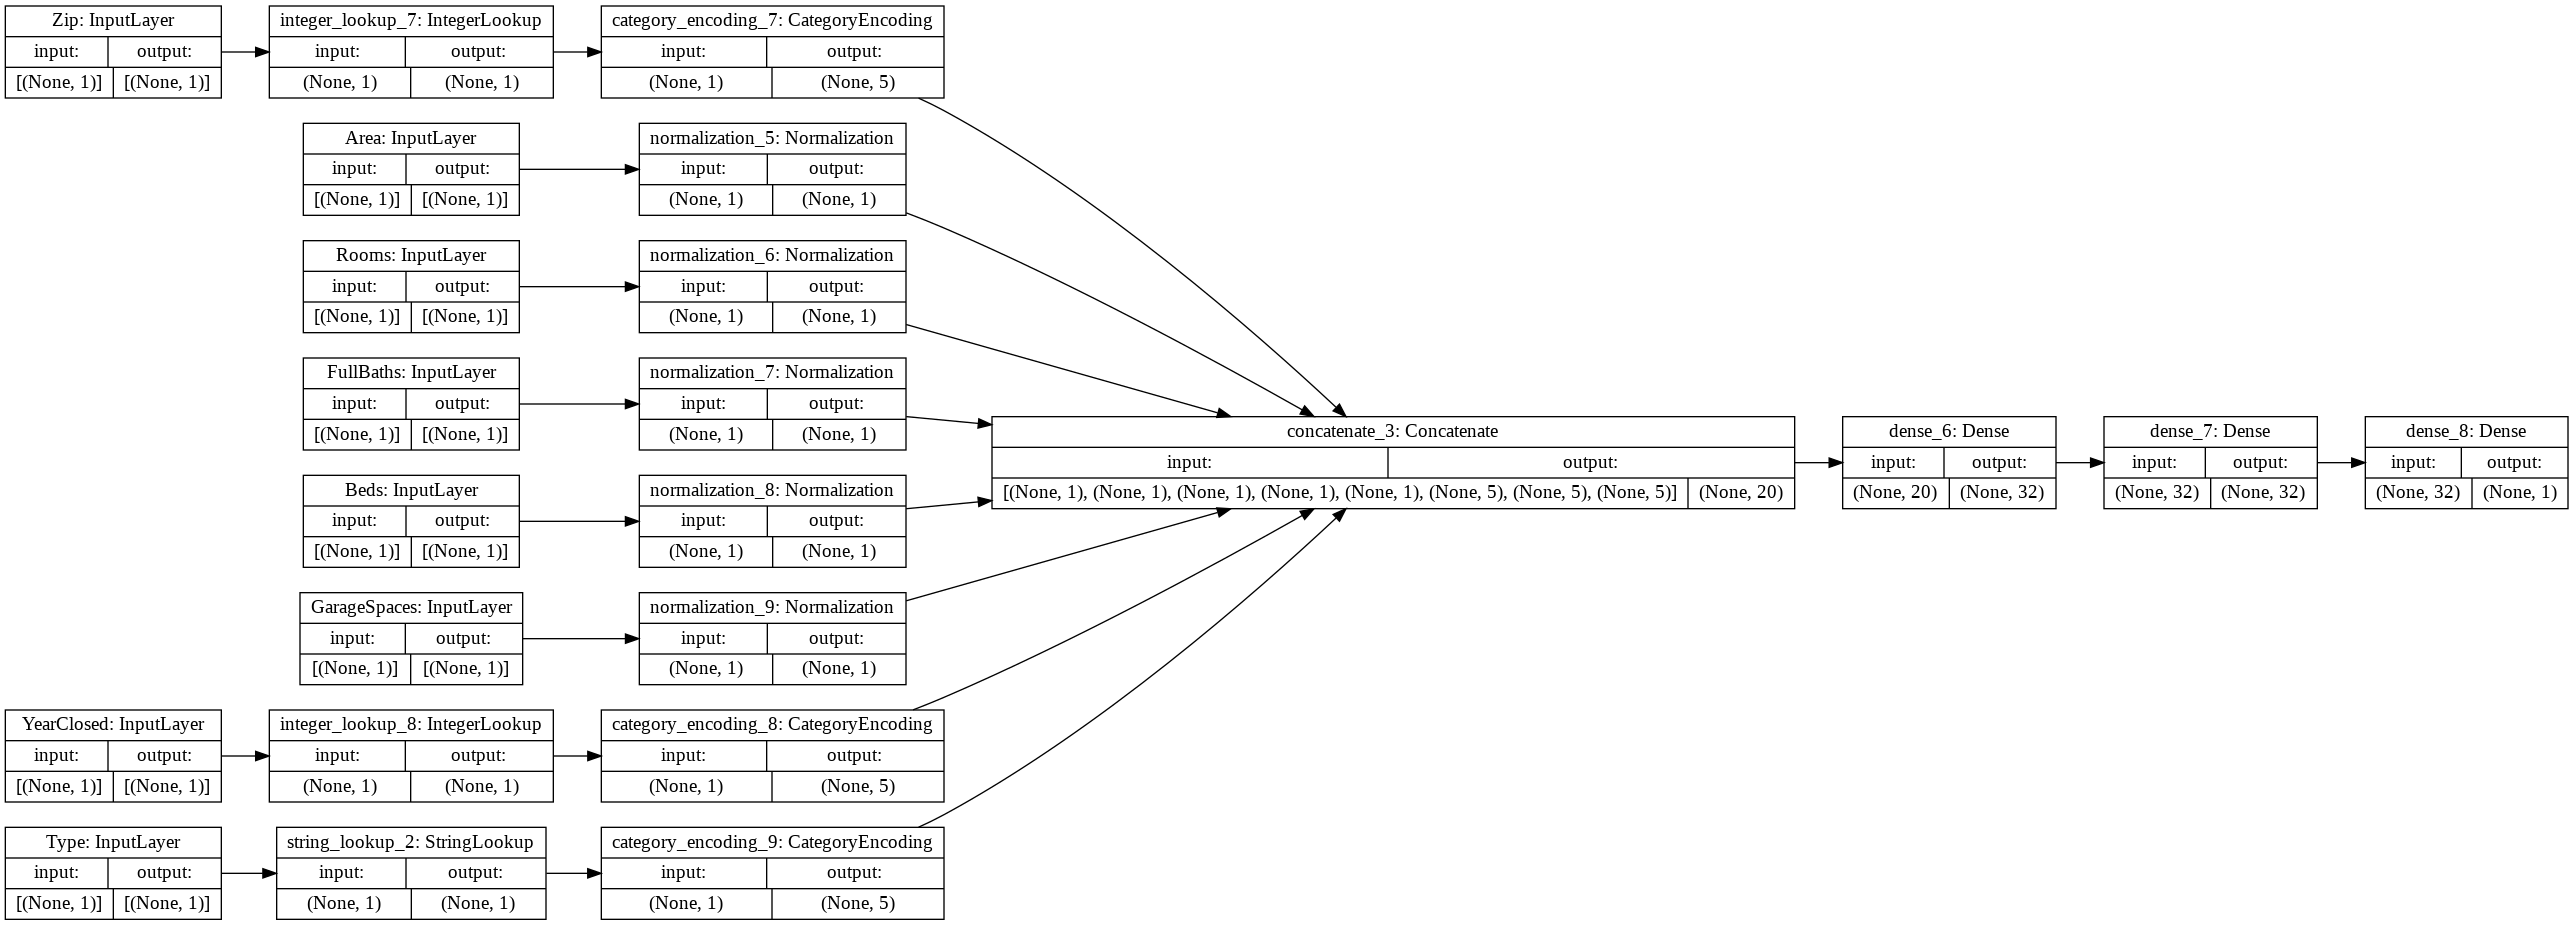

In [51]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [52]:
model.fit(train_ds, epochs=30, validation_data=val_ds)


Epoch 1/30
25/25 [==============================] - 1s 14ms/step - loss: 60253.4897 - accuracy: 0.0000e+00 - val_loss: -217955.7500 - val_accuracy: 0.0000e+00
Epoch 2/30
25/25 [==============================] - 0s 4ms/step - loss: -311140.9339 - accuracy: 0.0000e+00 - val_loss: -669085.0000 - val_accuracy: 0.0000e+00
Epoch 3/30
25/25 [==============================] - 0s 4ms/step - loss: -868753.5072 - accuracy: 0.0000e+00 - val_loss: -1588799.7500 - val_accuracy: 0.0000e+00
Epoch 4/30
25/25 [==============================] - 0s 4ms/step - loss: -1996875.2548 - accuracy: 0.0000e+00 - val_loss: -3527857.2500 - val_accuracy: 0.0000e+00
Epoch 5/30
25/25 [==============================] - 0s 4ms/step - loss: -4289333.9808 - accuracy: 0.0000e+00 - val_loss: -7202251.0000 - val_accuracy: 0.0000e+00
Epoch 6/30
25/25 [==============================] - 0s 4ms/step - loss: -8622590.9615 - accuracy: 0.0000e+00 - val_loss: -13604338.0000 - val_accuracy: 0.0000e+00
Epoch 7/30
25/25 [===============

In [53]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)


8/8 [==============================] - 0s 2ms/step - loss: -3156779264.0000 - accuracy: 0.0000e+00
Accuracy 0.0
